# Load necessary modules

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import mxnet as mx
import numpy as np
import pandas as pd

import logging
logging.getLogger().setLevel(logging.WARN)

# Load Data
1. Read the clean expression data and metadata file
2. Split the expression data columns from metadata columns and map classes (learning type) to number codes

In [3]:
dat = pd.read_csv('data/mice_proteins_cleaned.csv',index_col=0)
dat = dat.fillna(0)
dat.shape

(1080, 83)

In [ ]:
full_data_matrix = dat.iloc[:,:77].values

## Clean up the Learning Type codes

In [127]:
ltCodes = dict([(i,_) for i,_ in enumerate(sorted(set(dat.LearningType)))] + [(_,i) for i,_ in enumerate(sorted(set(dat.LearningType)))])
ltCodes

{0: 'failed',
 1: 'none',
 2: 'normal',
 3: 'rescued',
 'failed': 0,
 'none': 1,
 'normal': 2,
 'rescued': 3}

In [147]:
full_classes = np.array([ltCodes[_] for _ in dat.LearningType])

# Define the Neural Network

The input data are the expression values for all 77 proteins:

In [469]:
protExp = mx.sym.Variable('protein_expression')

These inner layers will act like 2 Principle Components (or Latent Factors):

In [470]:
PCAin  = mx.sym.FullyConnected(data=protExp, name='PCAin', num_hidden = 2)
PCAout  = mx.sym.FullyConnected(data=PCAin, name='PCAout', num_hidden = 77)

The classification layer assigns the "Principle Components" into one of 4 learning types:

In [471]:
classification = mx.sym.FullyConnected(data=PCAout, name='PCAclass', num_hidden = 4)

Finally, the learning-type labels are a Variable that informs a Soft Max function with loss learning function:

In [472]:
learningType = mx.symbol.Variable('learning_type')
softMax = mx.sym.SoftmaxOutput(data=classification, multi_output=True, preserve_shape=True, label=learningType, name="softMax")

### Put all the layers into a Module and visualize it:

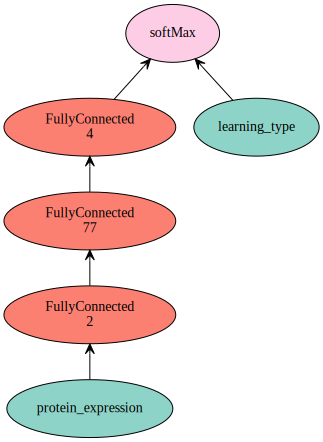

In [473]:
model = mx.mod.Module(
    symbol = softMax ,
    data_names=['protein_expression'],
    label_names = ['learning_type']
)
mx.viz.plot_network(symbol=softMax, node_attrs={"shape":"oval","fixedsize":"false"})

# Train the Neural Network
And save parameters from each epoch as a history for animations later

In [474]:
batch_size = 50
num_epoch = 100
rseed = 123

In [475]:
!rm data/models/mouse_classification_nn*

In [476]:
np.random.seed(rseed)
mx.random.seed(rseed)

model.bind(
    data_shapes=[('protein_expression', (batch_size,full_data_matrix.shape[1]))], 
    label_shapes=[('learning_type', (batch_size,))]
)

model.fit(
    mx.io.NDArrayIter(
        full_data_matrix,
        full_classes,
        batch_size=batch_size, 
        shuffle=True
    ),
    optimizer_params={
        'learning_rate':0.1, 
        'momentum': 0.9, 
        'lr_scheduler': mx.lr_scheduler.FactorScheduler(
            step=100, 
            factor=0.9
        )
    },
    num_epoch=num_epoch,
    eval_metric='mse',
    epoch_end_callback = mx.callback.do_checkpoint(
        "data/models/mouse_classification_nn", 
        int(max(1,num_epoch/100))
    )
)

In [477]:
acc = model.score(
    mx.io.NDArrayIter(
        full_data_matrix,
        full_classes,
        batch_size=batch_size, 
        shuffle=False
    ), 
    mx.metric.Accuracy()
)
print("Achieved {0:.3f} validation Accuracy".format(acc[0][1]))

Achieved 0.999 validation Accuracy


# Evaluate the inner layer to get projections

In [518]:
pca_extract = PCAin.eval(
    ctx=mx.cpu(),
    protein_expression=mx.nd.array(full_data_matrix),
    **model.get_params()[0]
)[0].asnumpy()
pca_extract.shape

(1080, 2)

In [480]:
dat['PC1'] = pd.Series(pca_extract[:,0], index=dat.index)
dat['PC2'] = pd.Series(pca_extract[:,1], index=dat.index)

In [528]:
colormap = {
    'failed':'red',
    'Saline':'red',
    'none':'green',
    'normal':'blue',
    'rescued':'purple',
    'Memantine':'purple'
}

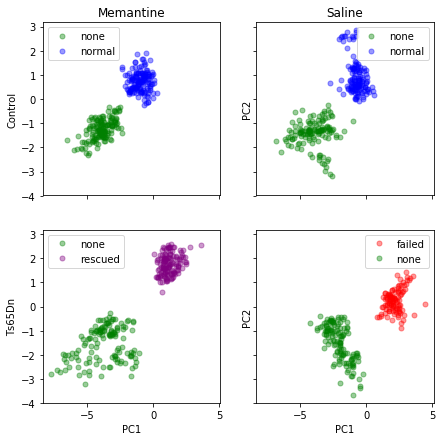

In [540]:
plti = -1
fig,axes = plt.subplots(2,2,True,True,figsize=(7,7))
for genotype, genotypeGroup in dat.groupby('Genotype'):
    for trt, treatmentGroup in genotypeGroup.groupby('Treatment'):
        plti += 1
        ax = axes.flatten()[plti]
        for name, group in treatmentGroup.groupby('LearningType'):
            ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name,alpha=.4, color=colormap[name])
        ax.legend()
        if plti<=1:
            ax.set_title(trt)
        else:
            ax.set_xlabel('PC1')
        if plti==0 or plti==2:
            ax.set_ylabel(genotype)
        if plti==1 or plti==3:
            ax.set_ylabel('PC2')


## The failed and rescued instances are now separated!

In [ ]:
plotDat = dat.loc[dat.Genotype=='Ts65Dn']#.loc[dat.LearningType!='none']

fig, ax = plt.subplots(figsize=(4,4))
ax.margins(0.05)
for name, group in plotDat.groupby('LearningType'):
    ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name, color=colormap[name], alpha=.5)
ax.legend()

ax.set_title('"Principle Components" in Ts65Dn Mice')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Load the parameters over the training epochs to animate the model learning

In [483]:
import os

In [484]:
pca_history = []
weight_history = []
dist_history = []
for fname in sorted(os.listdir('data/models')):
    if fname.endswith('params') and fname.startswith('mouse_classification_nn'):
        #print(fname)
        epoch = int(fname.split('-',1)[1].rsplit('.',1)[0])
        chkpt = mx.model.load_checkpoint('data/models/mouse_classification_nn',epoch)
        pca = PCAin.eval(ctx=mx.cpu(),protein_expression=mx.nd.array(full_data_matrix),**chkpt[1])[0].asnumpy()
        pca_history.append(pca)
        weight_history.append(chkpt[1]['PCAin_weight'].asnumpy().T)
        a = pca[np.where(dat.LearningType=='rescued'),:].mean(1)
        b = pca[np.where(dat.LearningType=='failed'),:].mean(1)
        dist_history.append(np.sqrt(np.power(a-b,2).sum()))
pca_history = np.array(pca_history)
weight_history = np.array(weight_history)
dist_history = np.array(dist_history)
pca_history.shape,weight_history.shape,dist_history.shape

((100, 1080, 2), (100, 77, 2), (100,))

In [515]:
!mkdir -p data/classification_pca_history
!rm data/classification_pca_history/*

In [531]:
!mkdir -p data/classification_pca_history_dn
!rm data/classification_pca_history_dn/*

rm: cannot remove 'data/classification_pca_history_dn/*': No such file or directory


In [535]:
plt.ioff()

for pci,pch in enumerate(pca_history):
    dat['PC1'] = pd.Series(pch[:,0], index=dat.index)
    dat['PC2'] = pd.Series(pch[:,1], index=dat.index)

    fig,axes = plt.subplots(2,2,True,True,figsize=(8,8))
    plti = -1
    for genotype, genotypeGroup in dat.groupby('Genotype'):
        for trt, treatmentGroup in genotypeGroup.groupby('Treatment'):
            plti += 1
            ax = axes.flatten()[plti]
            ax.set_xlim(pca_history.min((0,1))[0],pca_history.max((0,1))[0])
            ax.set_ylim(pca_history.min((0,1))[1],pca_history.max((0,1))[1])
            
            for name, group in treatmentGroup.groupby('LearningType'):
                ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name,alpha=.4, color=colormap[name])
            ax.legend()
            if plti<=2:
                ax.set_title(trt)
            else:
                ax.set_xlabel('PC1')
            if plti==1 or plti==3:
                ax.set_ylabel('PC2')
            if plti==2 or plti==4:
                ax.set_ylabel(genotype)
    fig.savefig('data/classification_pca_history/step_%04d.png'%pci)
    plt.close(fig)
    
    plotDat = pd.DataFrame(dat)
    plotDat.PC1 = pch[:,0]
    plotDat.PC2 = pch[:,1]
    plotDat = plotDat.loc[dat.Genotype=='Ts65Dn']#.loc[dat.LearningType!='none']
    fig, ax = plt.subplots(figsize=(4,4))
    ax.margins(0.05)
    ax.set_xlim(pca_history.min((0,1))[0],pca_history.max((0,1))[0])
    ax.set_ylim(pca_history.min((0,1))[1],pca_history.max((0,1))[1])
    for name, group in plotDat.groupby('LearningType'):
        ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name, color=colormap[name], alpha=.5)
    ax.legend()
    ax.set_title('"Principle Components" in Ts65Dn Mice')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    fig.savefig('data/classification_pca_history_dn/step_%04d.png'%pci)
    plt.close(fig)
plt.ion()

In [537]:
!convert -delay 10 -loop 0 data/classification_pca_history/*.png data/classification_pca_history/classification_pca_history.gif
!cp data/classification_pca_history/classification_pca_history.gif ./

In [538]:
!convert -delay 10 -loop 0 data/classification_pca_history_dn/*.png data/classification_pca_history_dn/classification_pca_history_dn.gif
!cp data/classification_pca_history_dn/classification_pca_history_dn.gif ./

![classification_pca_history.gif](classification_pca_history.gif)

![classification_pca_history_dn.gif](classification_pca_history_dn.gif)

# Investigate when the failed and rescued groups separated
The proteins whose input parameters changed during those epochs must be important for separating failed and rescued mouse learning.

Select the top proteins by "deltas," which are the parameter changes in Euclidean space from epoch to epoch

In [488]:
deltas = np.sqrt(np.power(weight_history[1:,:,:] - weight_history[:-1,:,:],2).sum(2))
deltas.shape

(99, 77)

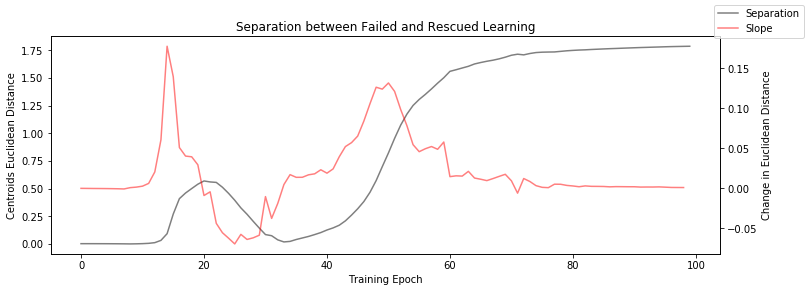

In [512]:
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dist_history,c='black',alpha=.5,label='Separation')

ax2 = ax1.twinx()
dist_history_slope = dist_history[1:]-dist_history[:-1]
ax2.plot(dist_history_slope,c='red',alpha=.5,label='Slope')

plt.title('Separation between Failed and Rescued Learning')

ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('Centroids Euclidean Distance')
ax2.set_ylabel('Change in Euclidean Distance')

fig.legend()

Text(0.5,0,'Training Epoch')

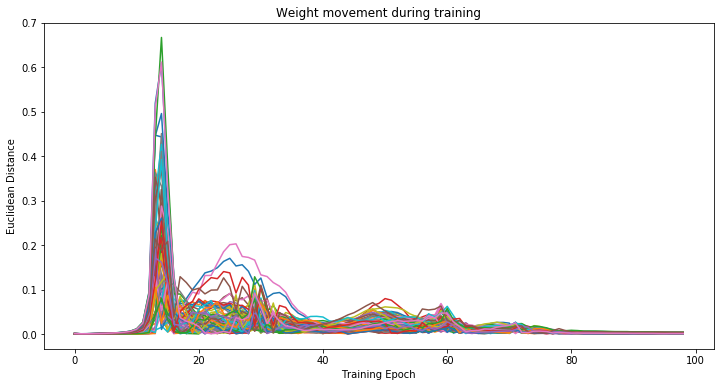

In [511]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(deltas)
ax.set_title('Weight movement during training')
ax.set_ylabel('Euclidean Distance')
ax.set_xlabel('Training Epoch')

## The most change happend around epoch 50

In [497]:
scores = deltas[45:55,:].sum(0)

In [498]:
scores_order = (-scores).argsort()

In [499]:
dat.columns[scores_order]

Index(['NUMB_N', 'GluR3_N', 'H3MeK4_N', 'BRAF_N', 'nNOS_N', 'P3525_N',
       'SNCA_N', 'pCAMKII_N', 'BAD_N', 'CDK5_N', 'Ubiquitin_N', 'ADARB1_N',
       'pERK_N', 'Tau_N', 'pRSK_N', 'GFAP_N', 'BCL2_N', 'DYRK1A_N', 'pP70S6_N',
       'pJNK_N', 'S6_N', 'ELK_N', 'GluR4_N', 'NR2B_N', 'P70S6_N', 'ERK_N',
       'P38_N', 'ITSN1_N', 'CREB_N', 'pGSK3B_Tyr216_N', 'pPKCG_N', 'BAX_N',
       'CaNA_N', 'pNR2A_N', 'TRKA_N', 'pELK_N', 'JNK_N', 'APP_N', 'RRP1_N',
       'ERBB4_N', 'RAPTOR_N', 'H3AcK18_N', 'pBRAF_N', 'IL1B_N', 'pNR2B_N',
       'AKT_N', 'AcetylH3K9_N', 'GSK3B_N', 'SYP_N', 'pCREB_N', 'EGR1_N',
       'SOD1_N', 'NR1_N', 'AMPKA_N', 'PKCA_N', 'RSK_N', 'DSCR1_N', 'NR2A_N',
       'TIAM1_N', 'pCASP9_N', 'PSD95_N', 'pPKCAB_N', 'pCFOS_N', 'pNUMB_N',
       'Bcatenin_N', 'pNR1_N', 'BDNF_N', 'SHH_N', 'MTOR_N', 'CAMKII_N',
       'pGSK3B_N', 'pMTOR_N', 'MEK_N', 'pMEK_N', 'pAKT_N', 'ARC_N', 'pS6_N'],
      dtype='object')

Text(0,0.5,'Weight movement during separating epochs')

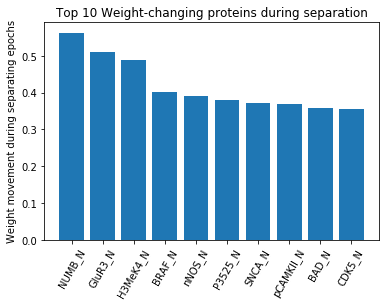

In [500]:
plt.bar(dat.columns[:77][scores_order][:10],scores[scores_order][:10])
plt.xticks(rotation=60)
plt.title('Top 10 Weight-changing proteins during separation')
plt.ylabel('Weight movement during separating epochs')

## Verify that the top proteins separate failed and rescued learning

Text(0,0.5,'GluR3')

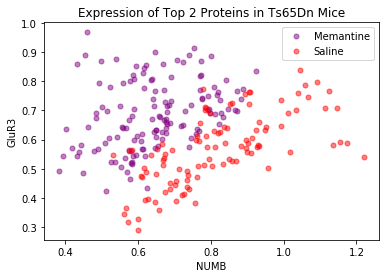

In [529]:
plotDat = dat.loc[dat.Genotype=='Ts65Dn'].loc[dat.LearningType!='none']

fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in plotDat.groupby('Treatment'):
    ax.plot(group.NUMB_N, group.GluR3_N, marker='o', linestyle='', ms=5, label=name, color=colormap[name], alpha=.5)
ax.legend()

ax.set_title('Expression of Top 2 Proteins in Ts65Dn Mice')
ax.set_xlabel('NUMB')
ax.set_ylabel('GluR3')


## ... and that they do not separate the same treatments in control mice

Text(0,0.5,'GluR3')

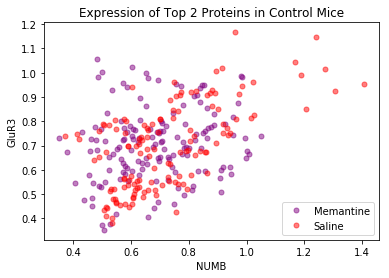

In [530]:
plotDat = dat.loc[dat.Genotype=='Control'].loc[dat.LearningType!='none']

fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in plotDat.groupby('Treatment'):
    ax.plot(group.NUMB_N, group.GluR3_N, marker='o', linestyle='', ms=5, label=name, color=colormap[name], alpha=.5)
ax.legend()

ax.set_title('Expression of Top 2 Proteins in Control Mice')
ax.set_xlabel('NUMB')
ax.set_ylabel('GluR3')
